In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

def read(filepath) -> pd.DataFrame():
    df = (pd.read_csv(filepath)
          .assign(Date = lambda x: pd.to_datetime(x['Date']),
                  Year = lambda x: (x['Date'].dt.year),
                  Month = lambda x: (x['Date'].dt.month),
                  Percentage_Change = lambda x: x.Price.pct_change()
                 )
          .fillna(0.0)
         )
    return df

oil_fp = 'BrentOilPrices.csv'

In [2]:
oil = read(oil_fp)

In [3]:
oil

,Date,Price,Year,Month,Percentage_Change
0,1987-05-20,18.63,1987,5,0.000000
1,1987-05-21,18.45,1987,5,-0.009662
2,1987-05-22,18.55,1987,5,0.005420
3,1987-05-25,18.60,1987,5,0.002695
4,1987-05-26,18.63,1987,5,0.001613
...,...,...,...,...,...
9006,2022-11-08,96.85,2022,11,-0.030239
9007,2022-11-09,93.05,2022,11,-0.039236
9008,2022-11-10,94.25,2022,11,0.012896
9009,2022-11-11,96.37,2022,11,0.022493


In [4]:
import prophet
from prophet import Prophet


In [5]:
df_prophet = oil[['Date', 'Price']]
# Prophet needs columns named 'ds' & 'y', so I'll make those changes too
df_prophet.columns = ['ds','y']

In [6]:
df_prophet

,ds,y
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
9006,2022-11-08,96.85
9007,2022-11-09,93.05
9008,2022-11-10,94.25
9009,2022-11-11,96.37


In [7]:
split_date = df_prophet.index.max()-36
train_df, test_df = df_prophet.loc[df_prophet.index <= split_date].set_index(['ds']).copy(), df_prophet.loc[df_prophet.index > split_date].set_index(['ds']).copy()

In [8]:
train_df

,y
ds,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
...,...
2022-09-16,89.43
2022-09-20,89.62
2022-09-21,89.86


In [9]:
test_df

,y
ds,
2022-09-26,82.55
2022-09-27,85.97
2022-09-28,89.55
2022-09-29,89.41
2022-09-30,88.90
2022-10-03,90.68
2022-10-04,93.74
2022-10-05,94.35
2022-10-06,95.65


In [10]:
# Importing libs
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from textwrap import wrap
import seaborn as sns

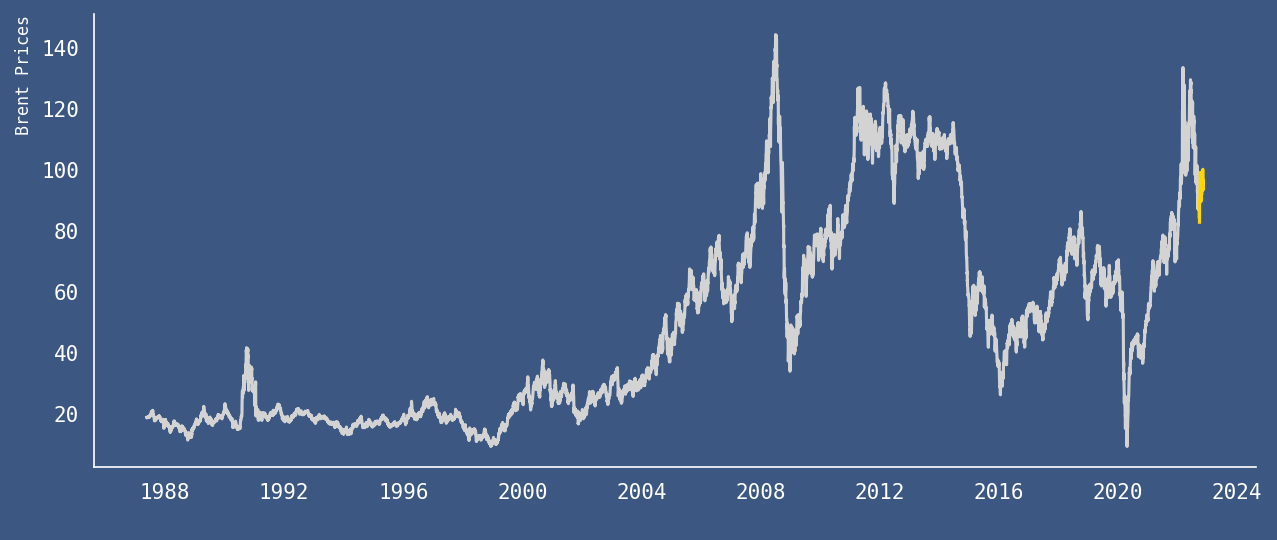

In [11]:
background_color = '#3B5782'
other = '#144082'
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams["font.family"] = "monospace"


fig = plt.figure(figsize=(10, 4), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)

sns.lineplot(ax=ax0, x=train_df.index, y='y', data=train_df,color='lightgray')
sns.lineplot(ax=ax0, x=test_df.index, y='y', data=test_df,color='gold')

Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()

ax0.set_ylabel("Brent Prices",fontsize=8,loc='top', fontfamily='monospace')
ax0.set_xlabel(" ",fontsize=8,loc='left', fontfamily='arial')
ax0.tick_params(axis = "both", which = "both", left=False, bottom=False)
ax0.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)

for s in ["left","bottom"]:
    ax0.spines[s].set_color('white')

  
plt.xticks(rotation=0)

plt.show()

In [12]:
model = Prophet()
model.fit(train_df.reset_index())

12:40:26 - cmdstanpy - INFO - Chain [1] start processing
12:40:32 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
test_preds = model.predict(df=test_df.reset_index())

In [15]:
test_preds.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [19]:
train_test_combined_df = train_df.join(test_preds.set_index(['ds'])[['yhat', 'yhat_lower','yhat_upper','trend']], how = 'outer')

In [20]:
train_test_combined_df= train_test_combined_df[-500:]

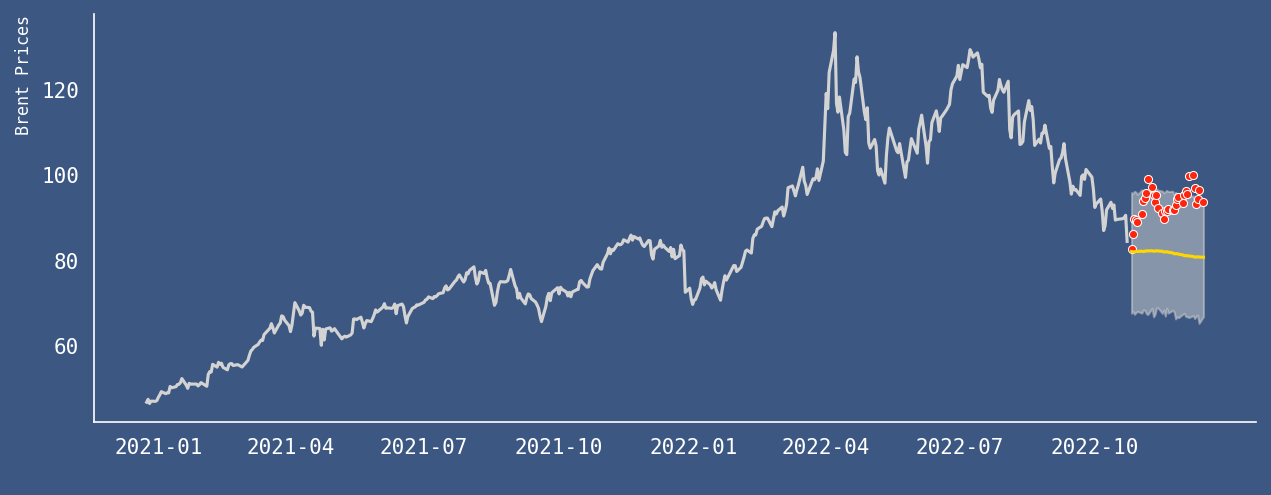

In [22]:
fig = plt.figure(figsize=(10, 4), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)

train_test_combined_df[['y','yhat']].plot(ax=ax0, color=['lightgray','gold'],legend=False)
#предсказанное
ax0.fill_between(train_test_combined_df.index, train_test_combined_df['yhat_upper'], train_test_combined_df['yhat_lower'], alpha=0.5, color='lightgray')
#разброс
ax0.scatter(test_df.index, test_df['y'], color='#FF240D',ec='white', linewidth=0.5, s=15)
#фактическое

Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()

ax0.set_ylabel("Brent Prices",fontsize=8,loc='top', fontfamily='monospace')
ax0.set_xlabel(" ",fontsize=8,loc='left', fontfamily='arial')
ax0.tick_params(axis = "both", which = "both", left=False, bottom=False)
ax0.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)

for s in ["left","bottom"]:
    ax0.spines[s].set_color('white')

plt.xticks(rotation=0)

plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt


print('Our error metrics: ')
mae = mean_absolute_error(y_true=test_df['y'], y_pred=test_preds['yhat'])
print(f'MSE: {mae}')

mse = mean_squared_error(y_true=test_df['y'], y_pred=test_preds['yhat'])
rmse = sqrt(mse)
print(f'RMSE: {rmse}')

Our error metrics: 
MSE: 11.709650931226063
RMSE: 12.297148437929872


In [24]:
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
import neuralprophet

In [25]:
train_df = train_df.reset_index()
test_df = test_df.reset_index()

In [26]:
m = NeuralProphet(seasonality_mode="multiplicative", learning_rate=0.05,epochs=100)

#df_train, df_test = m.split_df(df=train_df, freq="H", valid_p=0.1)

metrics_train = m.fit(df=train_df, freq="D") #metrics=True
metrics_test = m.test(df=test_df)

metrics_test

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.749% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
Epoch[100/100]: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s, SmoothL1Loss=0.0125, MAE=10.7, RMSE=16, Loss=0.0115, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.222% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - c:\Users\biaspaltsau_aa\Anaconda3\envs\torch\lib\site-packages\torch\nn\modules\loss.py:921: UserWarning: Using a target size (torch.Size([36]))

,SmoothL1Loss,MAE,RMSE
0,0.069493,38.162537,38.333256


INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.222% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.222% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


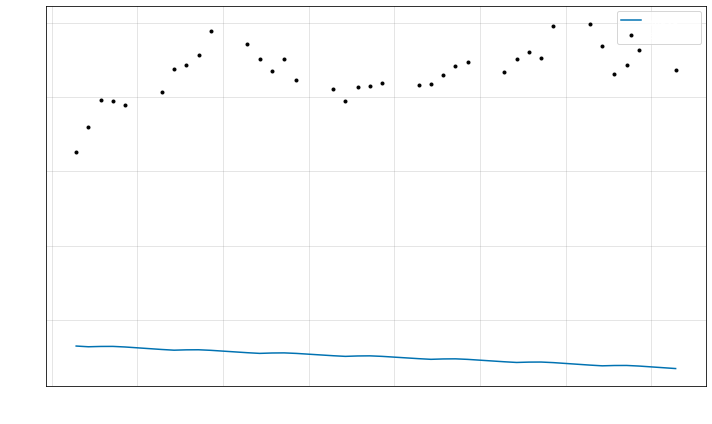

In [27]:
forecast = m.predict(test_df)
fig = m.plot(forecast)

---

In [28]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [30]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        
    
    #data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
    data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

    # выкидываем закодированные средними признаки 
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

In [31]:
df_prophet

,ds,y
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
9006,2022-11-08,96.85
9007,2022-11-09,93.05
9008,2022-11-10,94.25
9009,2022-11-11,96.37


In [32]:
df_ = df_prophet.copy()

In [33]:
df_.index = df_.ds

In [34]:
df_.drop(["ds"], axis=1,inplace=True)

In [50]:
import xgboost as xgb
from xgboost import XGBRegressor

X_train, X_test, y_train, y_test = prepareData(df_.y, 5, 16, 0.05)

In [51]:
X_train

,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,is_weekend,weekday_average,hour_average
0,18.75,18.68,18.65,18.58,18.60,18.60,18.63,18.60,18.55,18.45,18.63,0,46.376407,46.359548
1,18.78,18.75,18.68,18.65,18.58,18.60,18.60,18.63,18.60,18.55,18.45,0,46.348407,46.359548
2,18.65,18.78,18.75,18.68,18.65,18.58,18.60,18.60,18.63,18.60,18.55,0,46.453748,46.359548
3,18.75,18.65,18.78,18.75,18.68,18.65,18.58,18.60,18.60,18.63,18.60,0,46.427990,46.359548
4,18.78,18.75,18.65,18.78,18.75,18.68,18.65,18.58,18.60,18.60,18.63,0,46.376407,46.359548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8556,61.09,61.17,60.74,60.17,59.48,58.98,58.61,57.62,56.42,55.25,54.87,0,46.348407,46.359548
8557,62.47,61.09,61.17,60.74,60.17,59.48,58.98,58.61,57.62,56.42,55.25,0,46.453748,46.359548
8558,63.58,62.47,61.09,61.17,60.74,60.17,59.48,58.98,58.61,57.62,56.42,0,46.183250,46.359548
8559,63.96,63.58,62.47,61.09,61.17,60.74,60.17,59.48,58.98,58.61,57.62,0,46.427990,46.359548


In [52]:
y_train.head(20)

0     18.78
1     18.68
2     18.78
3     18.90
4     19.03
5     19.05
6     19.05
7     19.10
8     18.90
9     18.75
10    18.70
11    19.08
12    19.15
13    19.08
14    18.98
15    19.25
16    19.33
17    19.48
18    19.50
19    19.48
Name: y, dtype: float64

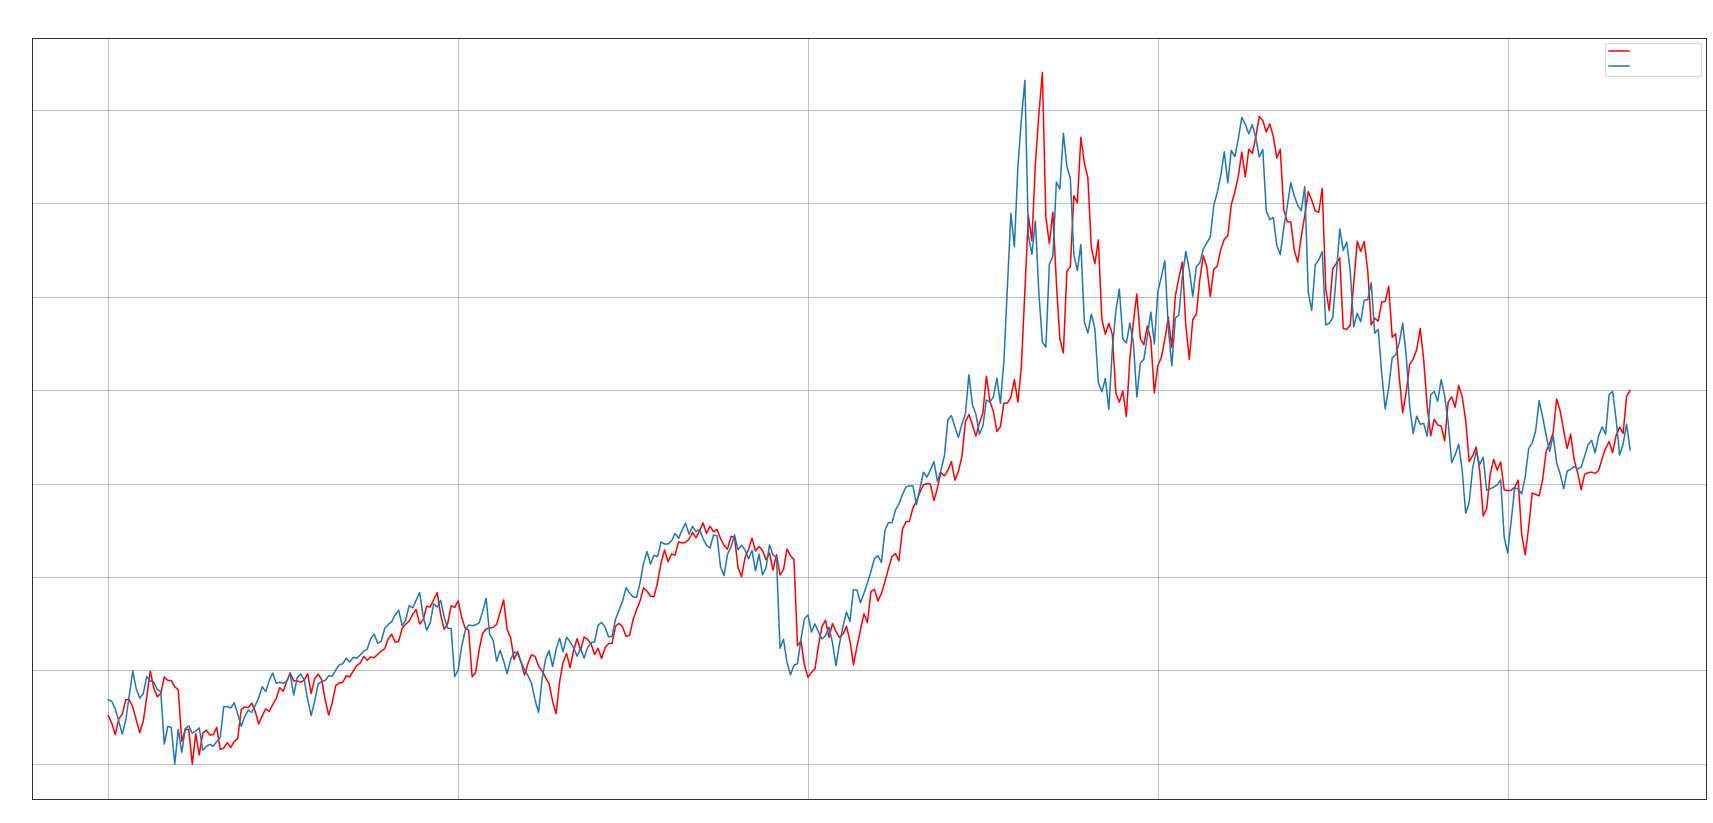

In [60]:
from sklearn.linear_model import LinearRegression, Ridge
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(30, 14))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [61]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,lr.predict(X_test))**0.5

5.651880411298031